<h1> Classification notebook </h1> <br> Holds all functions used for classification

In [200]:
# All functions used for preprocessing the data
import math
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cross_validation import train_test_split
import time

# Classifiers: 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans

def plot_correlation_heatmap(data):
    # Plot the correlation heatmap
    plt.figure(figsize=(12,10))
    sns.heatmap(data.corr(),cmap='seismic')
    plt.show()


def process_cabin(dataset):
    # Removes the cabin numbers and only retains general cabin regions
    # Also changes NaN to '-' indicating no cabin known
    cabin_area = []
    for cabin in dataset['Cabin']:
        if type(cabin) == float:
            assert math.isnan(cabin),'Cabins should not be float if not nan'
            cabin_area.append('-')
        else:
            cabin_area.append(cabin[0])
    dataset['Cabin'] = cabin_area
    return dataset

def add_fam_col(dataset):
    # Adds up parch and sibsp column to get a family size count
    parch = np.array(dataset['Parch'])
    sibsp = np.array(dataset['SibSp'])
    n = parch.shape[0]
    fam = np.array([parch[i] + sibsp[i] for i in range(n)])
    dataset['Fam'] = fam
    return dataset

def add_title_col(dataset):
    # Parses name information to retrieve the title of the passenger
    title = [x.split(',')[1].split('.')[0] for x in dataset['Name']]
    dataset['Title'] = title
    return dataset

def get_features_and_target(dataset):
    y = dataset['Survived']
    dataset.drop(labels=['Survived'],axis=1)
    return dataset, y

def handle_age_nan_mean(dataset):
    new_ages = []
    ages = dataset['Age']

    for i,age in enumerate(ages):
        if math.isnan(age):
            new_ages.append(np.mean(ages))
        else:
            new_ages.append(age)
    dataset['Age'] = new_ages
    return dataset

def handle_age_nan_discretize(dataset):
    new_ages = []
    ages = dataset['Age']

    for i,age in enumerate(ages):
        if math.isnan(age):
            new_ages.append('-')
        else:
            if age < 5:
                new_ages.append('baby')
            elif age < 10:
                new_ages.append('young_child')
            elif age < 15:
                new_ages.append('child')
            elif age < 18:
                new_ages.append('puber')
            elif age < 25:
                new_ages.append('adolescend')
            elif age < 35:
                new_ages.append('adult_young')
            elif age < 55:
                new_ages.append('adult_old')
            elif age < 70:
                new_ages.append('Elderly')
            else:
                new_ages.append('Almost_dead')
    assert len(ages) == len(new_ages)
    dataset['Age'] = new_ages
    return dataset

def convert_dummy_variables(dataset):
    # Convert categorical data into binary variables per category
    data = pd.get_dummies(dataset,columns=['Pclass','Sex','Cabin','Title','Embarked'])
    return data

def preprocess_data(data):
    # Add new features
    data = add_fam_col(data)
    data = add_title_col(data)
    data = process_cabin(data)
    data = handle_age_nan_mean(data)
    print(list(data.keys()))
    # Drop columns that we think won't be important
    data.drop(labels=['Ticket','PassengerId','Name'],axis=1, inplace=True)
    
    data = convert_dummy_variables(data)
    print(list(data.keys()))
    return data

def preprocess_data_test(data):
    # Add new features
    data = add_fam_col(data)
    data = add_title_col(data)
    data = process_cabin(data)
    data = handle_age_nan_mean(data)
    print(list(data.keys()))
    # Drop columns that we think won't be important
    data.drop(labels=['Ticket','Name'],axis=1, inplace=True)
    
    data = convert_dummy_variables(data)
    print(list(data.keys()))
    return data

data= pd.read_csv("train.csv")
data = preprocess_data(data)
X = data.iloc[:,1:]
y = data.iloc[:,0]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)



['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Fam', 'Title']
['Survived', 'Age', 'SibSp', 'Parch', 'Fare', 'Fam', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male', 'Cabin_-', 'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_T', 'Title_ Capt', 'Title_ Col', 'Title_ Don', 'Title_ Dr', 'Title_ Jonkheer', 'Title_ Lady', 'Title_ Major', 'Title_ Master', 'Title_ Miss', 'Title_ Mlle', 'Title_ Mme', 'Title_ Mr', 'Title_ Mrs', 'Title_ Ms', 'Title_ Rev', 'Title_ Sir', 'Title_ the Countess', 'Embarked_C', 'Embarked_Q', 'Embarked_S']


In [92]:
def kfold_cross_val(data,classifier,k,name, verbose):
    X = data.iloc[:,1:]
    y = data.iloc[:,0]
    n = data.shape[0]
    
    # For easy partitioning we remove some datapoints that would make the folds
    #  unbalanced
    
    excess = np.mod(n,k)
    
    # Create fold indices
    folds = np.random.permutation(n-excess).reshape((k,int(np.floor(n/k))))
    if verbose:
        print("_____________________________________________")
        print("{}-fold cross validation for {}:".format(k,name))
    # We calculate accuracy k times
    accs = []
    for i in range(k):
        # Take the ith fold as test set
        test_idx = folds[i,:]
        y_test = y.iloc[test_idx]
        X_test = X.iloc[test_idx]
        X_train = None
        y_train = None
        for j in range(k):
            # Take the remaining j folds as trainset
            if j != i:
                if not isinstance(X, pd.DataFrame):
                    X_train = X.iloc[folds[j,:]]
                    y_train = y.iloc[folds[j,:]]
                else:
                    X_train = pd.concat([X_train, X.iloc[folds[j,:]]])
                    y_train = pd.concat([y_train, y.iloc[folds[j,:]]])
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        test_n = len(y_pred)
        
        correct = sum([y_pred[i] == list(y_test)[i] for i in range(test_n)])
        accuracy = correct/test_n
        accs.append(accuracy)
        
        if verbose: print("Accuracy over fold {} is {}".format(i,accuracy))
    avg_accuracy = np.mean(np.array(accs))
    if verbose:
        print("AVERAGE ACCURACY {}: {}".format(name,avg_accuracy))
        print("_____________________________________________")
    return avg_accuracy
    


In [2]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def plot_classification(X,y_pred, y_test):
    print("Starting")
    plt.clf()
    tsne = TSNE(n_components=2, verbose=1, perplexity=50,n_iter=1000,random_state=0)
    tsne_results = tsne.fit_transform(X.values)
    tsne_comp1 = tsne_results[:,0]
    tsne_comp2 = tsne_results[:,1]
    plt.scatter(tsne_comp1, tsne_comp2, c=y_test, s=50)
    plt.scatter(tsne_comp1, tsne_comp2, c=y_pred,s=20)

    plt.show()
    

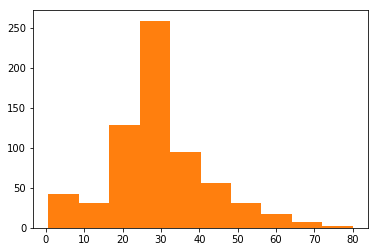

In [96]:
a = X_train['Age']
plt.hist(a)
plt.show()

In [9]:
rfcl = RandomForestClassifier(n_estimators=1000,n_jobs=4,random_state=0,bootstrap=True)
rfcl.fit(X_train, y_train)

y_pred = rfcl.predict(X_test)
correct = sum([y_pred[i] == list(y_test)[i] for i in range(len(y_test))])
print(correct/len(y_pred))


0.8340807174887892


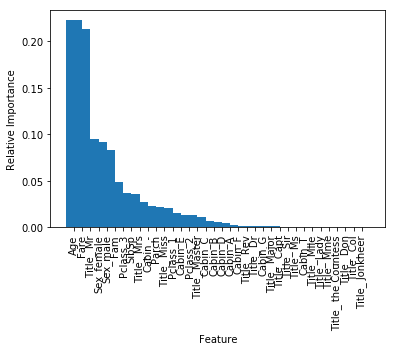

In [10]:
def plot_importance(rf_model,data):
    importances = np.array(rf_model.feature_importances_)
    idx_sorted = (-importances).argsort()
    importances = importances[idx_sorted]
    labels = np.array(data.keys())
    labels = labels[idx_sorted]
    ind = np.arange(len(labels))
    bars = plt.bar(ind,importances,2)
    plt.ylabel('Relative Importance')
    plt.xlabel('Feature')
    plt.xticks(ind,labels,rotation='vertical')
    plt.show()

plot_importance(rfcl, X_train)

In [53]:
from itertools import chain, combinations

def powerset(iterable):
    # Source: https://stackoverflow.com/questions/18035595/powersets-in-python-using-itertools
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

def find_best_combo():
    
    data= pd.read_csv("train.csv")
    data = preprocess_data(data)
    
    X = data.iloc[:,1:]
    y = data.iloc[:,0]
    
    # Find Relative importances of features
    rfcl = RandomForestClassifier(n_estimators=1000,n_jobs=4,random_state=0,bootstrap=True)
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    rfcl.fit(X_train, y_train)
    feature_importances = rfcl.feature_importances_
    
    features = [str(x) for x in list(X.keys())]
    
    # Avoid error of choosing more features than non-zero entries
    #  in feature_importances
    max_feat = (sum([x>0 for x in feature_importances]))
    
    assert len(feature_importances) == len(features)
    s = time.time()
    best_accuracy = 0
    best_features = None
     # Do 10.000 trials
    for j in range(10000):
        if j%100 == 0:
            print('Iteration {}'.format(j))
            print('Best acc: {}'.format(best_accuracy))
            print('Time passed: {}'.format(time.time()-s))
            print('___________________')
        # Choose features according to their relative importance.
        n_feat = np.random.choice(np.arange(2,max_feat))
        chosen_features = np.random.choice(features, 
                                           size = n_feat,
                                           replace=False,
                                           p=feature_importances)
    
        sub_columns = np.insert(chosen_features,0,'Survived')
        sub_data = data[sub_columns]
        # Initialise Logistic Regression Classifier
        lrcl = LogisticRegression(random_state=0)
        avg_accuracy = kfold_cross_val(sub_data,lrcl,10, 'Logistic Regression Classifier',False)

        if avg_accuracy > best_accuracy:
            best_accuracy = avg_accuracy
            best_features = chosen_features
    e = time.time()
    print("Finding best combination took {} seconds".format(e-s))
    return best_accuracy, best_features
                
    
        
accuracy, features = find_best_combo()
print(accuracy)
print(features)

Iteration 0
Best acc: 0
Time passed: 0.0006337165832519531
___________________
Iteration 100
Best acc: 0.8337078651685393
Time passed: 23.9054696559906
___________________
Iteration 200
Best acc: 0.8337078651685393
Time passed: 47.31798577308655
___________________
Iteration 300
Best acc: 0.8337078651685393
Time passed: 70.28307032585144
___________________
Iteration 400
Best acc: 0.8337078651685393
Time passed: 92.54131436347961
___________________
Iteration 500
Best acc: 0.8337078651685393
Time passed: 115.07750868797302
___________________
Iteration 600
Best acc: 0.8337078651685393
Time passed: 138.0529327392578
___________________
Iteration 700
Best acc: 0.8337078651685393
Time passed: 160.90311861038208
___________________
Iteration 800
Best acc: 0.8337078651685393
Time passed: 182.59169340133667
___________________
Iteration 900
Best acc: 0.8337078651685393
Time passed: 205.41076231002808
___________________
Iteration 1000
Best acc: 0.8337078651685393
Time passed: 228.32173943519

(891, 48)

In [157]:

data= pd.read_csv("train.csv")
data = preprocess_data(data)
X = data.iloc[:,1:]
y = data.iloc[:,0]
# Random Forest Classifier
rfcl = RandomForestClassifier(n_estimators=1000,n_jobs=4,random_state=0,bootstrap=True)
#kfold_cross_val(data,rfcl,10, 'Random Forest Classifier', True)
rfcl.fit(X,y)
n = X.shape[0]
y_pred = rfcl.predict(X)
correct = sum([y_pred[i] == list(y)[i] for i in range(n)])
accuracy = correct/n
print(accuracy)
# Logistic Regression Classifier
lrcl = LogisticRegression(random_state=0)
#kfold_cross_val(data,lrcl,10, 'Logistic Regression Classifier', True)
lrcl.fit(X,y)
y_pred = lrcl.predict(X)
correct = sum([y_pred[i] == list(y)[i] for i in range(n)])
accuracy = correct/n
print(accuracy)



['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Fam', 'Title']
['Survived', 'SibSp', 'Parch', 'Fare', 'Fam', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male', 'Cabin_-', 'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_T', 'Title_ Capt', 'Title_ Col', 'Title_ Don', 'Title_ Dr', 'Title_ Jonkheer', 'Title_ Lady', 'Title_ Major', 'Title_ Master', 'Title_ Miss', 'Title_ Mlle', 'Title_ Mme', 'Title_ Mr', 'Title_ Mrs', 'Title_ Ms', 'Title_ Rev', 'Title_ Sir', 'Title_ the Countess', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Age_-', 'Age_Almost_dead', 'Age_Elderly', 'Age_adolescend', 'Age_adult_old', 'Age_adult_young', 'Age_baby', 'Age_child', 'Age_puber', 'Age_young_child']
0.9640852974186308
0.8439955106621774


In [151]:

def plot_accuracy(classifier, name):
    accs = []
    for i in range(50):
        print(i)
        acc = kfold_cross_val(data,classifier,10, 'Logistic Regression Classifier', False)
        accs.append(acc)
    ax = sns.violinplot(y=accs)
    plt.ylim(0.75,0.84)
    plt.ylabel('Accuracy')
    plt.title('{}'.format(name))
    plt.suptitle('10-fold cross validation')
    plt.suptitle('Training Set Accuracy')
    plt.savefig(name+'_fold.png')
    plt.show()


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


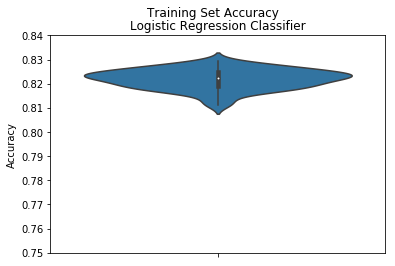

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


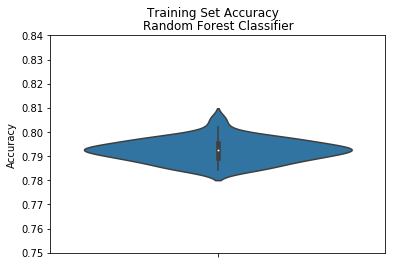

In [152]:
plot_accuracy(lrcl,'Logistic Regression Classifier')
plot_accuracy(rfcl,'Random Forest Classifier')


In [201]:
def get_test_data():
    # makes test data ready for prediction
    test_data= pd.read_csv("test.csv")
    test_data = preprocess_data_test(test_data)
    del test_data['Title_ Dona']
    fares = test_data['Fare']
    new = []
    for fare in fares:
        if math.isnan(fare ):
            new.append(np.mean(fares))
            print(str(np.mean(fares)))
            print("NAN FOUND")
        else:
            new.append(fare )
    test_data['Fare'] = new
    test_data['Cabin_T']  = [int(x) for x in np.zeros((418,1))]
    test_data['Title_ Don']  = [int(x) for x in np.zeros((418,1))]
    test_data['Title_ Capt'] = [int(x) for x in np.zeros((418,1))]
    test_data['Title_ Jonkheer'] = [int(x) for x in np.zeros((418,1))]
    test_data['Title_ Lady'] = [int(x) for x in np.zeros((418,1))]
    test_data['Title_ Major'] = [int(x) for x in np.zeros((418,1))]
    test_data['Title_ Mlle'] = [int(x) for x in np.zeros((418,1))]
    test_data['Title_ Mme'] = [int(x) for x in np.zeros((418,1))]
    test_data['Title_ Sir'] = [int(x) for x in np.zeros((418,1))]
    test_data['Title_ the Countess'] = [int(x) for x in np.zeros((418,1))]
    return test_data


In [203]:
test_data= get_test_data()
ids = test_data['PassengerId']
del test_data['PassengerId']
print(test_data.shape)
data= pd.read_csv("train.csv")
data = preprocess_data(data)
print(data.shape)
X = data.iloc[:,1:]
y = data.iloc[:,0]

lrcl = LogisticRegression(random_state=0)

lrcl.fit(X,y)
y_pred = lrcl.predict(test_data)
test_data['predictions'] = y_pred
for i,el in enumerate(y_pred):
    print(el)


['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Fam', 'Title']
['PassengerId', 'Age', 'SibSp', 'Parch', 'Fare', 'Fam', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male', 'Cabin_-', 'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G', 'Title_ Col', 'Title_ Dona', 'Title_ Dr', 'Title_ Master', 'Title_ Miss', 'Title_ Mr', 'Title_ Mrs', 'Title_ Ms', 'Title_ Rev', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
35.627188489208635
NAN FOUND
(418, 39)
['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Fam', 'Title']
['Survived', 'Age', 'SibSp', 'Parch', 'Fare', 'Fam', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male', 'Cabin_-', 'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_T', 'Title_ Capt', 'Title_ Col', 'Title_ Don', 'Title_ Dr', 'Title_ Jonkheer', 'Title_ Lady', 'Title_ Major', 'Title_ Mas